# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Model definition

In [1]:
import openturns as ot
import numpy as np
import pandas as pd

In [2]:
ot.__version__

'1.16'

In [3]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [4]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

In [5]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis. 
    * Uses LeastSquaresStrategy to compute the coefficients from 
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials 
    in the basis using least angle regression stepwise (LARS)
    * Utilise LeastSquaresStrategy pour calculer les 
    coefficients par moindres carrés. 
    * Uses FixedStrategy to keep all coefficients that LARS has selected, 
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector
    
    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerate_function = multivariateBasis.getEnumerateFunction()
    P = enumerate_function.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [6]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [7]:
training_sample_size = 50  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

In [8]:
totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [9]:
metamodel = result.getMetaModel()  # get the metamodel
type(metamodel)

openturns.func.Function

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [10]:
test_sample_size = 1000  # Size of the validation design of experiments
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [11]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictability coefficient

In [12]:
Q2 = val.computePredictivityFactor()[0]
Q2

0.9935498537159522

Plot the observed versus the predicted outputs.

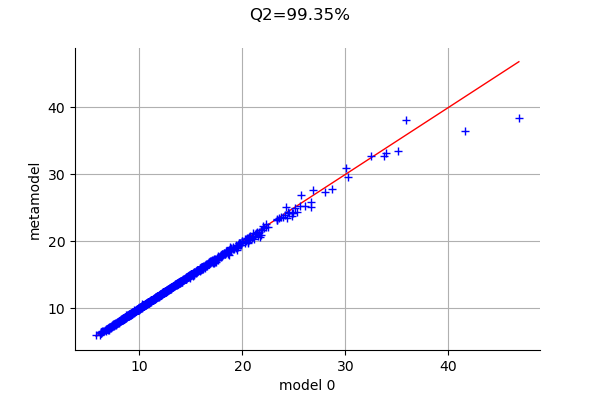

In [13]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
graph

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [14]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
print(chaosSI.summary())

 input dimension: 4
 output dimension: 1
 basis size: 25
 mean: [12.5763]
 std-dev: [4.18011]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      2 | [0,1,0,0]                     | 0.776796
      1 | [1,0,0,0]                     | 0.134289
      4 | [0,0,0,1]                     | 0.0583109
      6 | [1,1,0,0]                     | 0.0100374
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.136147               | 0.147643              
        1 | 0.777299               | 0.795029              
        2 | 0.00882986             | 0.00981764            
        3 | 0.0585995              | 0.0667767             
-------------------------------

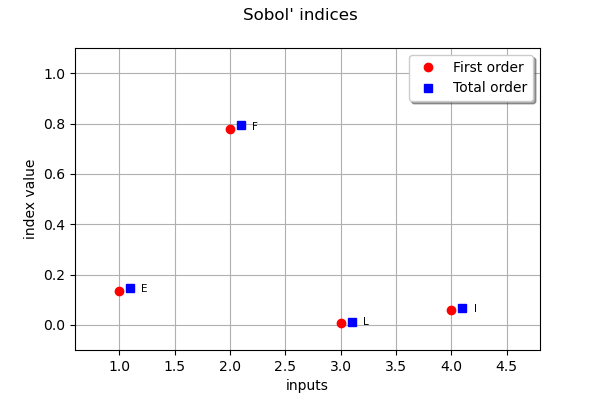

In [15]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

## Solution de l'exercice 1 : réduction de la taille du plan d'expériences d'apprentissage


Puisque nous réduisons la taille du plan d'expérience, il s'avère que le calcul d'un chaos de qualité est plus difficile. Pour rendre l'estimation des coefficients moins sensible au plan d'expériences, nous suggérons de réduire le degré du polynôme. Un degré maximum égal à 1 fonctionne souvent correctement.

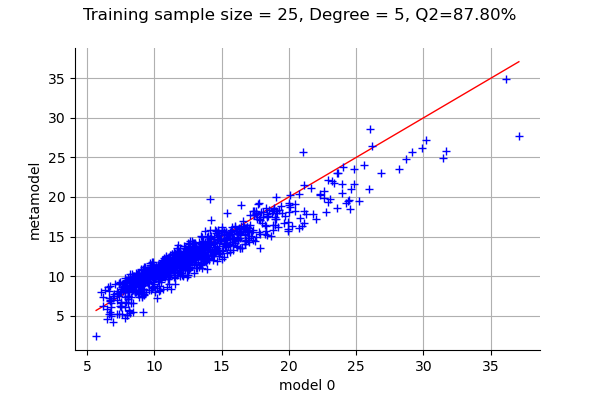

In [16]:
training_sample_size = 25  # size of the experimental design
inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)
#
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
metamodel = result.getMetaModel()  # get the metamodel
#
test_sample_size = 1000
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
graph = val.drawValidation()
graph.setTitle("Training sample size = %d, Degree = %d, Q2=%.2f%%" % (training_sample_size, totalDegree, 100 * Q2))
graph

On observe que le coefficient $Q^2$ est moins élevé qu'avec le plan d'expériences précédent. 

In [17]:
def compute_degree_sensitivity(
    myDistribution,
    g,
    training_sample_size,
    test_sample_size,
    multivariateBasis,
    degree_array,
    verbose=False,
):
    """
    Compute a table reflecting the sensitivity to the polynomial degree.
    
    The content is:
    * first column : polynomial degree
    * second column : predictability coefficient Q2
    * third column : number of coefficients
    
    Parameters
    ----------
    myDistribution : ot.Distribution
        The input distribution.
    g : ot.Function
        The model.
    training_sample_size : int
        The size of the training sample.
    test_sample_size : int
        The size of the test sample.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    degree_array : list of int
        The list of maximum total polynomial degrees
    verbose : bool
        If True, print messages.
    
    Returns
    -------
    data : numpy array((len(degree_array), 3))
        The results of the experiment.
    """
    data = np.zeros((len(degree_array), 3))
    index = 0
    for totalDegree in degree_array:
        # 1. Fit
        inputTrain = myDistribution.getSample(training_sample_size)
        outputTrain = g(inputTrain)
        result = ComputeSparseLeastSquaresChaos(
            inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
        )
        metamodel = result.getMetaModel()  # get the metamodel
        # 2. Test
        inputTest = myDistribution.getSample(test_sample_size)
        outputTest = g(inputTest)
        val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
        Q2 = val.computePredictivityFactor()[0]
        coefficients = result.getCoefficients()
        numberOfParameters = coefficients.getSize()
        if verbose:
            print(
                "Sample size=%d, degree=%d, Q2=%.4f %%"
                % (training_sample_size, totalDegree, Q2)
            )
        data[index, :] = (totalDegree, Q2, numberOfParameters)
        index += 1
    return data

In [18]:
test_sample_size = 1000
sample_size_array = [25, 50, 100]
degree_array = list(range(1, 6))
for training_sample_size in sample_size_array:
    print("Sample size=", training_sample_size)
    data = compute_degree_sensitivity(
        myDistribution,
        g,
        training_sample_size,
        test_sample_size,
        multivariateBasis,
        degree_array,
        verbose=False,
    )
    metrics = ["Poly. degree", "Q2", "N. parameters"]
    df = pd.DataFrame(data, columns=metrics)
    print(df)

Sample size= 25
   Poly. degree        Q2  N. parameters
0           1.0  0.977057            5.0
1           2.0  0.995835           11.0
2           3.0  0.991434            9.0
3           4.0  0.951249            9.0
4           5.0 -0.342636            4.0
Sample size= 50
   Poly. degree        Q2  N. parameters
0           1.0  0.976568            5.0
1           2.0  0.998764           14.0
2           3.0  0.998739           18.0
3           4.0  0.639365            3.0
4           5.0  0.999857           23.0
Sample size= 100
   Poly. degree        Q2  N. parameters
0           1.0  0.977728            5.0
1           2.0  0.999586           13.0
2           3.0  0.999970           31.0
3           4.0  0.999998           45.0
4           5.0  0.982076           21.0


On observe que le coefficient de prédictivité est sensible à la taille du plan d'expériences. Pour un plan d'expériences de taille 25, le coefficient de prédictivité peut être négatif, ce qui révèle un très mauvais métamodèle. Pour un plan d'expériences de taille 50, le coefficient de prédictivité est la plupart du temps très bon. Toutefois, augmenter le degré du polynôme au delà du degré 2 n'améliore pas beaucoup la qualité. Pour un plan d'expériences de taille 100, le coefficient de prédictivité est toujours très bon. 

In [19]:
training_sample_size = 100
print("Sample size=", training_sample_size)
degree_array = range(1, 20, 2)
data = compute_degree_sensitivity(
        myDistribution,
        g,
        training_sample_size,
        test_sample_size,
        multivariateBasis,
        degree_array,
        verbose=False,
    )
metrics = ["Poly. degree", "Q2", "N. parameters"]
df = pd.DataFrame(data, columns=metrics)
print(df)

Sample size= 100
   Poly. degree        Q2  N. parameters
0           1.0  0.974148            5.0
1           3.0  0.999982           26.0
2           5.0  0.999028           44.0
3           7.0  0.997110           17.0
4           9.0  0.999780           18.0
5          11.0  0.998589           40.0
6          13.0  0.984495           25.0
7          15.0  0.994481           32.0
8          17.0  0.999298           52.0
9          19.0  0.996766           16.0


On observe que pour un plan d'expériences de taille 100, augmenter le degré du polynôme au delà de 3 n'est pas très utile. En effet, le degré 3 permet d'obtenir un Q2 égal à 0.99 avec seulement 16 coefficients. Lorsqu'on augmente le degré total, la méthode de sélection de modèle n'identifie que très peu de coefficients supplémentaires et ces coefficients n'améliorent pas beaucoup la qualité.  

Pour améliorer la qualité du métamodèle, plusieurs options sont possibles.
1. La taille du plan d'expériences pourrait être augmentée. C'est une option qui nécessite d'évaluer la fonction $g$ sur un plus grand nombre de points d'entrée, ce qui peut être coûteux.
1. Le degré du polynôme pourrait être modifié. En effet, un polynôme de degré moins élevé est associé à un moins grand nombre de coefficients, qui sont plus faciles à estimer. Au contraire, il peut s'avérer que le modèle est très nonlinéaire, ce qui peut nécessiter un degré polynomial élevé.
1. On peut changer de plan d'expériences et utiliser, par exemple, une séquence à faible discrépance ou un plan LHS. C'est une option qui nécessite d'évaluer la fonction $g$ sur des nouveaux points d'entrée, ce qui peut être coûteux.
1. On pourrait changer la base polynomiale orthogonale univariée. Par exemple, il se peut que la base orthogonale associée à la loi log-normale pose une difficulté dans ce cas particulier (car la distribution log-normale n'est pas déterminée de manière unique par ses moments). On pourrait remplacer la famille de polynômes associée à la variable $F$ par la famille des polynômes de Laguerre, qui est également associée à des variables positives comme la loi log-normale.
1. On pourrait changer la règle d'énumération par une règle qui favorise les coefficients associés aux degrés élevés, sans augmenter excessivement le nombre de coefficients, comme la règle hyperbolique par exemple.

## Solution de l'exercice 2 : pourquoi éviter le calcul du R2

Get the relative error of the metamodel on the training sample, compute $R^2$.

In [20]:
result.getRelativeErrors()[0]

0.0051443975539611645

$R^2$ indicator:

In [21]:
R2 = 1 - result.getRelativeErrors()[0]
print(r"R2 = %.4f" % R2)

R2 = 0.9949


On observe que le coefficient $R^2$ est très proche de 1. Cela laisse penser que le métamodèle est d'excellente qualité, ce qui peut être vrai ou faux en fonction des situations. Dans tous les cas, ce n'est pas nécessairement une bonne métrique pour qualifier le métamodèle : on préfère en général utiliser un plan d'expérience de validation et calculer le coefficient $Q^2$. 

## Solution de l'exercice 3

In [22]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    """
    Create a plot of total degree vs absolute value of coefficients.
    
    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos result
    
    Returns
    -------
    graph : ot.Graph
        A plot.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerate_function = basis.getEnumerateFunction()
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    abscoeff = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    nbcoeffs = indices.getSize()
    total_p = []
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        totaldegree = sum(multiindex)
        total_p.append(totaldegree)
    #
    graph = ot.Graph(
        "Polynomial chaos result",
        "Total polynomial degree",
        "Coefficient absolute value",
        True,
    )
    cloud = ot.Cloud(total_p, abscoeff)
    graph.add(cloud)
    return graph

Plot the coefficients absolute values as a function of total polynomial degree: high degree polynomials contribute less than low-degree terms to the response's variability

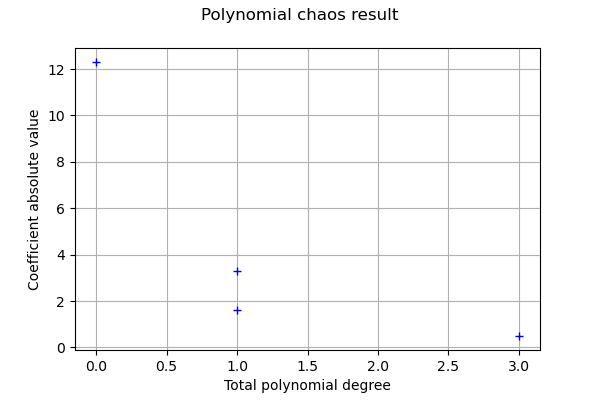

In [23]:
plotCoefficientValueVSDegree(result)

## Solution de l'exercice 4 : énumération hyperbolique et plan d'expériences de taille 25


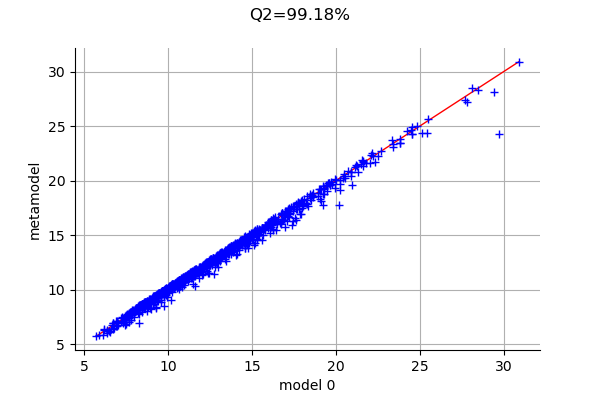

In [24]:
dim_input = 4
polyColl = ot.PolynomialFamilyCollection(dim_input)
polyColl[0] = ot.StandardDistributionPolynomialFactory(dist_E)
polyColl[1] = ot.StandardDistributionPolynomialFactory(dist_F)
polyColl[2] = ot.StandardDistributionPolynomialFactory(dist_L)
polyColl[3] = ot.StandardDistributionPolynomialFactory(dist_I)
#
q = 0.6  # the q-quasi-norm parameter
enumerate_function = ot.HyperbolicAnisotropicEnumerateFunction(dim_input, q)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerate_function)
#
N = 25  # size of the experimental design
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)
#
approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
projectionStrategy = ot.LeastSquaresStrategy(
    inputTrain, outputTrain, approximationAlgorithm
)
totalDegree = 5
P = enumerate_function.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
chaosalgo = ot.FunctionalChaosAlgorithm(
    inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()
#
result = chaosalgo.getResult()
metamodel = result.getMetaModel()  # get the metamodel
#
test_sample_size = 1000
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (100 * Q2))
graph

The metamodel is more accurate than using a linear enumeration.

## Solution de l'exercice 5 : nombre d'observations et nombre de paramètres

In [25]:
coefficients = result.getCoefficients()
numberOfParameters = coefficients.getSize()
numberOfParameters

8

In [26]:
trainingSampleSize = inputTrain.getSize()
trainingSampleSize

25

In [27]:
learningRatio = trainingSampleSize / numberOfParameters
learningRatio

3.125

Si le nombre d'observations est très supérieur au nombre de paramètres, alors l'apprentissage est de qualité. Avec environ 2 observations par paramètres, le nombre d'observations est suffisant, mais il pourrait être plus grand pour assurer une meilleure qualité. 

## Solution de l'exercice 6 : analyse des résultats de la sélection de modèle

In [28]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.
    
    Parameters
    ----------
    enumerate_function : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerate_function = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Indice, Multi-indice, Degree : Value")
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k, multiindex, degree, c))
    return

Display active polynomials 

In [29]:
indices = result.getIndices()
indices

[0,1,2,3,4,13,16,17]

Display active polynomials coefficients

In [30]:
nbcoeffs = indices.getSize()
nbcoeffs

8

In [31]:
coefficients = result.getCoefficients()
coefficients

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=8 dimension=1 data=[[12.5827],[-1.56585],[3.74145],[0.416024],[-0.897802],[-0.481664],[0.114293],[-0.340581]]

Print the "sparsity" ratio as the complementary number of selected coefficients divided by total number of candidate polynomials in the basis.

In [32]:
sparsityRatio = 1.0 - nbcoeffs / P
print("%.2f %%" % (sparsityRatio * 100.0))

65.22 %


Le coefficient de creux est égal à 52%, ce qui est plutôt le signe d'un chaos polynomial de qualité. Comme ce ratio n'est ni trop petit ni trop grand, on peut légitimement conserver la valeur de `P` que l'on a choisie.

Print polynomials degrees and coefficients for active terms

In [33]:
printCoefficientsTable(result)

# Indice, Multi-indice, Degree : Value
#0, [0,0,0,0] (0) : 12.582747801774673
#1, [1,0,0,0] (1) : -1.56585477873976
#2, [0,1,0,0] (1) : 3.7414459227413905
#3, [0,0,1,0] (1) : 0.4160239541456497
#4, [0,0,0,1] (1) : -0.8978018807714074
#5, [1,1,0,0] (2) : -0.48166442998091963
#6, [0,1,1,0] (2) : 0.11429298945719346
#7, [0,1,0,1] (2) : -0.3405809546378037
